This notebook contains the code for my forest fire prediction regression project. The entire github repository can be found at https://github.com/grahamgreene88/Forest-Fire-Predicition. 

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Project Objective / Business Relevance

The objective of this project is to predict the area of forest firest that occured in Montesinho Natural Park in
Portugal. In recent years forest fires have become a large concern worlwide. Specifically here in Canada, the
recent forest fire season in the summer of 2023 resulted in large burn areas and unprecended smoky conditions across North America. 

Predicting the area of forest fires can be very useful for firefighting resource management and to help choose
which targets to prioritize with limited resources. This is relevant to future summers here in Canada with forest
fire occurences expected to increase in upcoming years due to increasing global temperatures.

## Exploratory Data Analysis

In [56]:
df = pd.read_csv('forestfires.csv')
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


The dataset contains 517 observations, 12 features and 1 target variable (area). The features fall into three categories:
- spacial coordinates: X and y spacial coordinates within Montesinho Park map.
- temporal variables: month and day of the week
- meteoroligical variables: temp, RH, wind, rain (FFMC, DMC, DC and ISI are components of the Canadian system for rating fire danger)

The target variable "area burned" is measured in hectares (ha) where 1 ha = 100 m^2. Values of zero mean that an area lower than 1 ha was burned.

In [57]:
df.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

There are no missing values in this dataset.

/Users/graham/anaconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


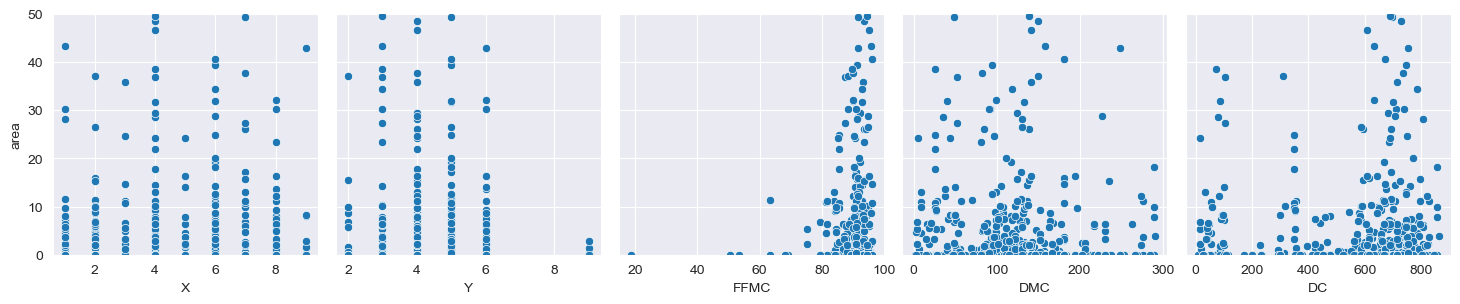

In [58]:
sns.pairplot(data=df, y_vars='area', x_vars=df.iloc[:, [0, 1, 4, 5, 6]].columns, kind='scatter', height=3)
plt.ylim(0,50)
plt.show()

/Users/graham/anaconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


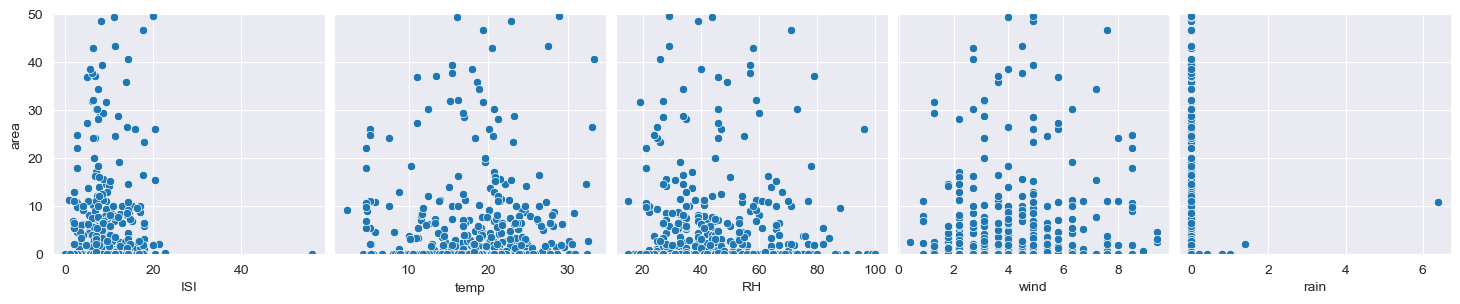

In [59]:
sns.pairplot(data=df, y_vars='area', x_vars=df.iloc[:, 7:12].columns, kind='scatter', height=3)
plt.ylim(0,50)
plt.show()

The scatterplots above show that as the area changes, the trends in the numerical features are very weak. This could make it hard for the model to pick up on these very weak trends in the data.

The heatmap of pearson correlation's below supports that observation as all of the features have very low correlation with fire area. Pearson's correlation only denotes linear trends.

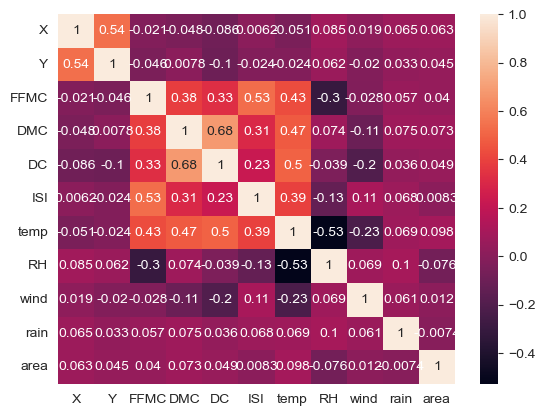

In [60]:
# Subset df to only include numerical features
df_num = df.drop(['month', 'day'], axis=1)
sns.heatmap(df_num.corr(), annot=True)
plt.show()

In [61]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


The output above shows the range of each variable. The range of the target variable (area) is important to note
here, with a min of 0 a max of 1091 and a mean of only 12.85. Let's checkout the distribution:

In [62]:
zero_obs = len(df[df['area'] == 0])
print(f"There are {zero_obs} observations with a burn area of 0 ha. That is almost half of the dataset.")

There are 247 observations with a burn area of 0 ha. That is almost half of the dataset.


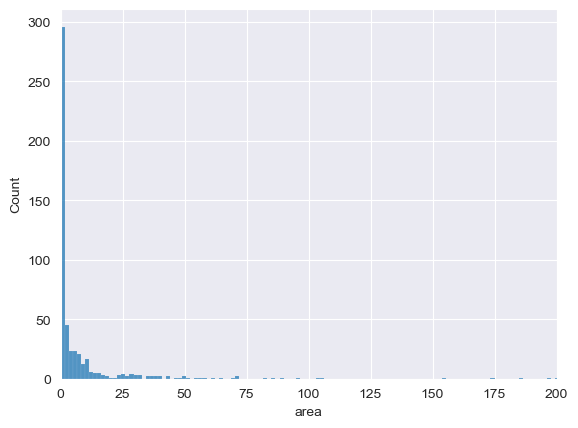

In [63]:
# Plotting distribution of target variable, area
sns.histplot(data=df, x='area')
sns.set_style('darkgrid')
plt.xlim(0, 200)
plt.show()

Target variable distribution is clearly heavily right-skewed. This is due to all the observations with zero area (less than 1 ha). To improve the skewness, the log(1+x) function will be applid to all target variable values. This transformation can help improve regression results for right-skewed target variables.

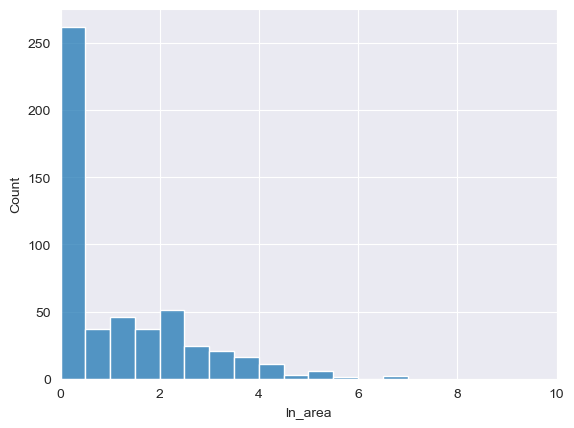

In [64]:
# Applying ln(1+x) transformation to area column, actually ln(1+x) despite log1p name
df['ln_area'] = np.log1p(df['area'])
df = df.drop('area', axis=1)
# Plotting the transformed distribution
sns.histplot(data=df, x='ln_area')
sns.set_style('darkgrid')
plt.xlim(0, 10)
plt.show()

Target variable is still right-skewed but less so. This will hopefully improve regression performance.

In [65]:
# Displaying feature data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   X        517 non-null    int64  
 1   Y        517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   FFMC     517 non-null    float64
 5   DMC      517 non-null    float64
 6   DC       517 non-null    float64
 7   ISI      517 non-null    float64
 8   temp     517 non-null    float64
 9   RH       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  ln_area  517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


All data types are in numeric format except the month and day of the week columns. The categorical variables will be encoded and the numerical features will be scaled to ensure they are suitable for a range of model types. For scaling, the numeric variables will be standardized so each one has a mean of 0 and unit variance.

**Note: the data will be separated into train and test sets at this point to avoid information leakage. Without this split, information from the test set would be learned during feature scaling which could artificially improve performance on unseen data (test set).**

In [66]:
# Separating features and target variable
X = df.drop('ln_area', axis=1)
y = df['ln_area']
# Performing train_test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=10)

In [67]:
# Standardizing data
from sklearn.preprocessing import StandardScaler
# Standardizing numeric features of train set
scaler = StandardScaler()
numeric_cols = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
scaler.fit(X_train[numeric_cols])
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])

The test set will now be standardized using the scaler fit on the train set (it is important that the scaler is not fit on the test set here to prevent information leakge)

In [68]:
# Standardizing test set with scaler fit on train set
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
X_test.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,-0.057956,-0.138343,0.071984,-0.173326,-0.066123,-0.003282,-0.035793,-0.099121,0.144928,0.344584
std,1.013235,0.889505,0.791126,0.880904,0.983438,0.830910,1.084417,1.095393,1.204455,5.252061
min,-1.606171,-1.858708,-6.926885,-1.675798,-2.155849,-1.817110,-2.594067,-1.865745,-1.802310,-0.116052
25%,-1.063962,-0.272556,-0.019810,-0.951154,-0.507274,-0.458319,-0.649438,-1.032957,-0.740675,-0.116052
50%,-0.304870,-0.272556,0.200216,-0.132934,0.317767,-0.089655,0.028103,-0.357298,0.026061,-0.116052
75%,0.996431,0.520520,0.390042,0.338750,0.619790,0.415941,0.639649,0.396926,0.851777,-0.116052
max,1.863966,1.313596,0.959520,2.473501,1.096521,2.880724,2.527084,3.099560,3.210965,59.766662


It is seen above that the features are not perfectly scaled to mean of 0 and std dev. of 1. This is a consequence of transforming the unseen data using a scaler fit on the seen data and properly mimics real-world conditions.

In [69]:
# Creating function to encode data
def encode(df):
    # Encoding categorical variables
    df_encoded = pd.get_dummies(df, drop_first=True)
    col = df_encoded.select_dtypes(include='bool').columns
    df_encoded[col] = df_encoded[col].astype('int')
    return df_encoded

In [70]:
# Encoding cat variables of train and test set
X_train = encode(X_train)
X_test = encode(X_test)
print(f"Train set features: {X_train.columns}.")
print(f"Train set features: {X_test.columns}.")

Train set features: Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue',
       'day_wed'],
      dtype='object').
Train set features: Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'month_aug', 'month_dec', 'month_feb', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_oct', 'month_sep', 'day_mon',
       'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed'],
      dtype='object').


The train set has more features than the test set. This is due to a small number of fires that occured during the winter months that all ended up in the test set. These observations will be removed along with the corresponding features to ensure feature consistency. The months are January and November.

In [71]:
# Counting observations that occur in jan and nov
nov_cols = X_train[X_train['month_jan'] != 0]
jan_cols = X_train[X_train['month_nov'] != 0]
print(f"There are {len(nov_cols) + len(jan_cols)} observations that occured in November or January.")

There are 3 observations that occured in November or January.


In [72]:
X_train.shape

(387, 27)

In [73]:
# Dropping 3 observations in these months
nov_index = X_train.index[X_train['month_jan'] != 0]
jan_index = X_train.index[X_train['month_nov'] != 0]
X_train.drop(nov_index, axis=0, inplace=True)
X_train.drop(jan_index, axis=0, inplace=True)
X_train.shape

(384, 27)

In [74]:
# Dropping nov and jan features (which now contain only zeros)
cols_to_drop = ['month_nov', 'month_jan']
X_train.drop(cols_to_drop, axis=1, inplace=True)
X_train.shape

(384, 25)

In [75]:
# Ensuring train and test sets now contains same number of features
assert len(X_train.columns) == len(X_test.columns)

In [76]:
# The 3 observations are also dropped from y_test
y_train.drop(nov_index, axis=0, inplace=True)
y_train.drop(jan_index, axis=0, inplace=True)
y_train.shape

(384,)

In [77]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(X_train)
pca.explained_variance_ratio_.sum()

0.857186821753448

In [114]:
pca.components_

array([[ 1.56007722e-01,  1.66504456e-01, -3.10966877e-01,
        -4.34722503e-01, -4.67865249e-01, -3.22757794e-01,
        -4.79194780e-01,  2.27191499e-01,  1.53549516e-01,
        -2.18477428e-02, -1.27978951e-01,  1.64355044e-02,
         5.65300214e-02,  1.33066338e-03,  1.07702341e-02,
         9.17138117e-02,  1.55547216e-03,  5.33079808e-03,
        -6.98020454e-02,  1.70511598e-02,  2.09032313e-03,
         2.83530697e-03, -1.00334172e-02, -6.24772442e-03,
        -1.28583988e-02],
       [ 5.57075568e-01,  5.32253397e-01,  8.17943200e-02,
         2.69886217e-01,  1.25693891e-01,  1.97086977e-01,
        -2.87469803e-02,  3.36256362e-01,  1.31842237e-01,
         3.56673067e-01,  8.97168816e-02,  1.68530486e-03,
        -1.74379291e-02,  8.44301773e-03,  1.03800846e-02,
        -3.71530576e-02, -2.69798019e-03, -4.99028206e-03,
        -4.67999636e-02, -2.96566535e-02, -6.45540955e-03,
         2.34507824e-02, -4.62722259e-03, -3.94330413e-03,
         7.95676538e-03],
    

In [115]:
print(pd.DataFrame(pca.components_,columns=X_train.columns,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8']))

             X         Y      FFMC       DMC        DC       ISI      temp  \
PC-1  0.156008  0.166504 -0.310967 -0.434723 -0.467865 -0.322758 -0.479195   
PC-2  0.557076  0.532253  0.081794  0.269886  0.125694  0.197087 -0.028747   
PC-3 -0.386772 -0.417483 -0.034328  0.210645  0.155362 -0.011997 -0.282949   
PC-4 -0.005159 -0.085801  0.206999 -0.264606 -0.320271  0.501948  0.099474   
PC-5  0.010451 -0.047712 -0.115680 -0.162718 -0.058732 -0.354278  0.281618   
PC-6 -0.082692 -0.106423  0.220392 -0.162516 -0.304908  0.485063 -0.148205   
PC-7  0.536801 -0.465048  0.080450 -0.326810  0.337428  0.107549 -0.142916   
PC-8  0.439672 -0.504758 -0.262449  0.222638 -0.242641 -0.072442  0.246130   

            RH      wind      rain  ...  month_mar  month_may  month_oct  \
PC-1  0.227191  0.153550 -0.021848  ...   0.091714   0.001555   0.005331   
PC-2  0.336256  0.131842  0.356673  ...  -0.037153  -0.002698  -0.004990   
PC-3  0.499469  0.332930  0.394002  ...  -0.027119  -0.000305  -0.007

In [79]:
X_train

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_mar,month_may,month_oct,month_sep,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
35,0.562664,-1.065632,-0.041381,-0.502674,0.715377,-0.574185,-0.130283,1.088297,0.320959,-0.116052,...,0,0,0,1,0,0,0,0,1,0
481,-0.304870,-1.065632,0.459069,0.010093,0.031809,0.099943,1.981532,-1.425781,0.556878,-0.116052,...,0,0,0,0,0,0,0,1,0,0
488,-0.304870,-0.272556,0.786950,0.419393,0.215754,1.827398,0.080898,1.653965,2.149330,-0.116052,...,0,0,0,0,0,0,0,0,1,0
347,0.128897,-0.272556,0.269243,-0.224228,0.776023,0.121010,-1.555758,1.905373,-0.209858,-0.116052,...,0,0,0,1,0,0,0,0,0,0
505,-1.606171,-1.858708,0.079417,0.752615,0.772408,0.226343,1.365586,-0.608706,-1.271493,-0.116052,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-0.738637,-0.272556,-1.059538,-0.613748,0.481229,-1.227247,-0.183079,0.019814,-0.504757,-0.116052,...,0,0,0,1,0,0,0,0,1,0
369,-0.304870,0.520520,0.079417,2.473501,1.096521,-0.405653,-0.904615,2.031076,2.149330,-0.116052,...,0,0,0,1,0,0,1,0,0,0
320,0.562664,-1.065632,0.390042,0.080084,0.929444,-0.321387,-0.007094,-0.671558,1.913412,-0.116052,...,0,0,0,1,0,0,0,1,0,0
125,-0.738637,-0.272556,0.355528,-1.023048,0.561153,-0.047522,0.292080,-1.300077,0.851777,-0.116052,...,0,0,1,0,0,0,1,0,0,0


In [110]:
X_train_pca = pca.transform(X_train)
X_train_pca

384

In [89]:
X_test_pca = pca.transform(X_test)
X_test_pca

array([[-0.79577505,  1.24591866, -1.50324293, ..., -0.98601726,
        -0.73151101,  0.2568508 ],
       [-0.27111808,  0.1005667 , -0.58109443, ...,  0.00529808,
         1.31202096, -0.04247538],
       [-1.88363511, -1.75189667,  1.16720916, ..., -0.2971419 ,
        -0.5025003 ,  0.86289014],
       ...,
       [ 0.65143284,  0.58538216,  0.24313476, ...,  0.69799205,
         1.68299841, -0.14219566],
       [-0.01919826, -1.03074529, -0.67961902, ...,  1.20471451,
        -0.21753966, -1.36997697],
       [ 1.0728447 , -1.73209977, -0.97231348, ...,  0.27562575,
        -0.57363024, -0.2076652 ]])

## Modeling

Cross validation will be performed for several different models using their default parameters and evaluated using root mean squared error (MSE). The hyperparameters of the best performing model will then be optimized.

### Cross-Validation

In [22]:
# Importing models, cross-validation and pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

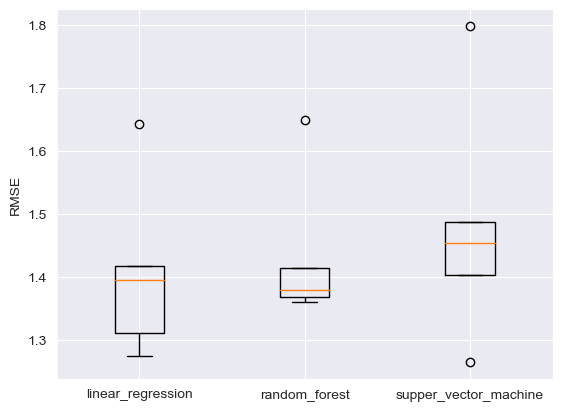

[array([1.31061699, 1.27493853, 1.41718629, 1.64266522, 1.39547716]), array([1.36885431, 1.35974577, 1.41493174, 1.64865762, 1.37991918]), array([1.40268191, 1.26478723, 1.45374307, 1.79838526, 1.48735542])]


In [83]:
# Performing cross validation for three models
models = {'linear_regression': LinearRegression(), 'random_forest': RandomForestRegressor(), 'supper_vector_machine':
         SVR()}
results=[]
for model in models.values():
    kf = KFold(n_splits=5, shuffle=True, random_state=10)
    cv_mse = -cross_val_score(model, X_train_pca, y_train.values, cv=kf, scoring='neg_mean_squared_error')
    # appending RMSE scores from cross-val for each model to the list of results
    results.append(cv_mse ** 0.5)
    
# Visualizing the RMSE from 5-fold cross-validation for each model
plt.boxplot(results, labels=models.keys())
plt.ylabel('RMSE')
plt.show()
print(results)

In 5-fold cross-validation, the linear regression model performs the best with the lowest median RMSE. The performance of each model on the unseen test set will now be determined.

In [90]:
# Evaluating performance on test set
from sklearn.metrics import mean_squared_error as MSE
for name, model in models.items():
    model.fit(X_train_pca, y_train.values)
    y_pred = model.predict(X_test_pca)
    rmse_test = MSE(y_test, y_pred) ** 0.5
    print(f'{name} test set RMSE: {rmse_test.round(2)}')

linear_regression test set RMSE: 1.56
random_forest test set RMSE: 1.45
supper_vector_machine test set RMSE: 1.56


The random forest model performs the best on the unseen test set with a RMSE of 1.46. This discrepancy between the cross-validation and test scores reflect the model characteristics. Random forest is less likely to overfit the training data because it is comprised of many individual, independant decision trees that are each fitted on random subsets of the training set.

### Optimizing Hyperparameters

Due to its high performance (lowest RMSE) on the unseen data, the random forest model will be chosen for further optimization. Hyperparameter optimzation will be performed using GridSearchCV.

The most important hyperparameters for random forest models are the number of decision trees (n_estimators) and the maximum depth of each decision tree (max_depth).

In [91]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(random_state=10)
# Defining hyperparameters to search over
rf_params={'n_estimators': [10, 50, 100, 500], 'max_depth': [3, 6, 9], 'max_features': ['sqrt', 'log2', None],
          'max_samples': [None, 0.3, 0.7]}
gridCV = GridSearchCV(rf, rf_params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gridCV.fit(X_train_pca, y_train.values)
# Printing the optimal set of hyperparameters
best_model = gridCV.best_estimator_
print(best_model)

RandomForestRegressor(max_depth=3, max_features='log2', n_estimators=50,
                      random_state=10)


In [92]:
print(f"Cross validation RMSE for optimal random forest hyperparameters: {(gridCV.best_score_ * -1)**0.5}")

Cross validation RMSE for optimal random forest hyperparameters: 1.3800738361790983


In [105]:
# Calculating RMSE for optimal RF on test set
y_pred_rf = best_model.predict(X_test_pca)
RMSE_test = MSE(y_test, y_pred_rf) ** 0.5
print(f"The optimal RF model achieves an RMSE of {RMSE_test.round(3)} on the test set")

The optimal RF model achieves an RMSE of 1.416 on the test set


**It is important to remember the ln(1+x) transformation we applied to the target variable during prepocessing. This transformation must be undone in order to get an accurate representation of model metrics like RMSE.**

In [94]:
# Creating new dataframe for untransformed target values
y_pred_rf = pd.Series(y_pred_rf)
y_df = pd.concat([y_test.reset_index(drop=True), y_pred_rf.reset_index(drop=True)], axis=1)
y_df.rename(columns = {0:'ln_area_pred'}, inplace=True)

In [95]:
# Apply reverse transformation to each column (e^x - 1)
cols = y_df.columns
for col in cols:
    y_df[col] = np.exp(y_df[col]) - 1
# Renaming columns to area
y_df.rename(columns = {'ln_area':'area', 'ln_area_pred':'area_pred'}, inplace=True)
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
y_df

,area,area_pred
0,86.45,4.305792
1,0.00,1.684956
2,0.00,1.479854
3,7.31,1.886164
4,2.01,1.590188
...,...,...
125,0.00,1.653041
126,24.59,1.687261
127,0.52,1.573928
128,0.00,2.344550


### Evaluating Results

In [97]:
# Recalculate RMSE for transformed test set
y_test_list = y_df['area'].tolist()
y_pred_list = y_df['area_pred'].tolist()
RMSE_test_final = MSE(y_test_list, y_pred_list) ** 0.5
# RMSE_test_final = MSE(pd.Series(y_df['area']), pd.Series(y_df['area_pred'])) ** 0.5
print(f"The optimal RF model achieves a transformed RMSE of {RMSE_test_final.round(3)} ha on the test set.")

The optimal RF model achieves a transformed RMSE of 98.52 ha on the test set.


The RMSE for the transformed target variables is very large. This indicates the model has poor accuracy since most of the areas are well below 98 ha. 

Upon further examination of the test and predictd areas, it can be seen that the model predicts small fires (with low area) quite well. However, it predicts small areas for very large fires which is the main reason the RMSE is so large. The model likely does not have enough observations for large fires to learn how to predict them accurately since most of the fire areas are close to 0 (with roughly half of them actually 0).

In [104]:
# Calculating MAD (mean absolute deviation)
from sklearn.metrics import mean_absolute_error as MAE
mae = MAE(y_test_list, y_pred_list)
mae

17.20642222464118

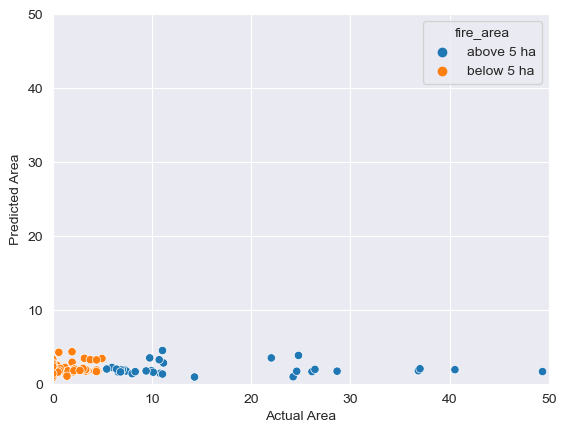

In [99]:
# Creating new column to visually separate small and large fires in plot
y_df['fire_area'] = y_df['area'] * 1
y_df['fire_area'] = y_df['fire_area'].apply(lambda x: 'below 5 ha' if x < 5 else 'above 5 ha')
y_df
# Plotting actual area vs predicted area values
sns.scatterplot(data=y_df, y='area_pred', x='area', hue='fire_area')
plt.xlabel("Actual Area")
plt.ylabel("Predicted Area")
plt.xlim(0,50)
plt.ylim(0,50)
plt.show()

The predicted vs actual plot above shows how the model can somewhat accurately predict small fire areas but it consistently fails to predict large fire areas. It incorrectly predicts all large fire areas as small.

In [101]:
# Dataframe of true y_train values and fit y values from trained model
y_fit_rf = best_model.predict(X_train_pca)
y_fit_rf = pd.Series(y_fit_rf)
fit_df = pd.concat([y_train.reset_index(drop=True), y_fit_rf.reset_index(drop=True)], axis=1)
fit_df.rename(columns={'ln_area':'y_true', 0:'y_fit'}, inplace=True)
fit_df.sort_values(by='y_true', ascending=True, inplace=True)
fit_df.reset_index(inplace=True, drop=True)
# remove transformation
cols = fit_df.columns
for col in cols:
    fit_df[col] = np.exp(fit_df[col]) - 1

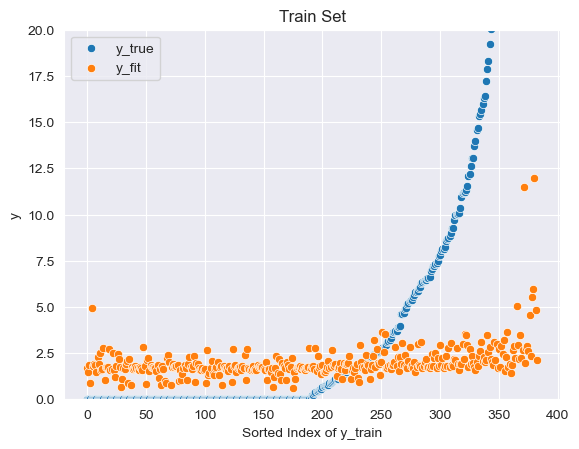

In [107]:
# Plotting y_train vs sorted index of y_train
ax = sns.scatterplot(data=fit_df, y='y_true', x=fit_df.index, label="y_true")
# Plotting y_fit values
sns.scatterplot(data=fit_df, y='y_fit', x=fit_df.index, ax=ax, label="y_fit")
plt.xlabel("Sorted Index of y_train")
plt.ylabel("y")
plt.ylim(0,20)
plt.title("Train Set")
plt.legend()
plt.show()

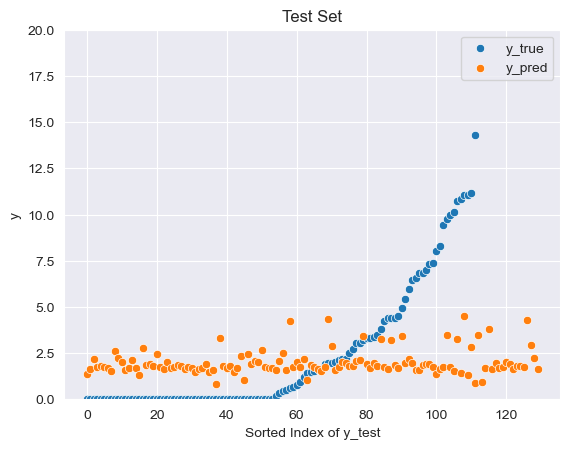

In [103]:
# Sorting index of y_df
y_df.sort_values(by='area', ascending=True, inplace=True)
y_df.reset_index(drop=True, inplace=True)
# Plotting y_test vs sorted index of y_test
ax = sns.scatterplot(data=y_df, y='area', x=y_df.index, label='y_true')
# Plotting y_pred values
sns.scatterplot(data=y_df, y='area_pred', x=y_df.index, ax=ax, label='y_pred')
plt.xlabel("Sorted Index of y_test")
plt.ylabel("y")
# plt.xlim(0,20)
plt.ylim(0,20)
plt.title("Test Set")
plt.show()

The two visualizations above show the true y values for both the train and test plotted against the fit and predicted values from the trained model. 

The model performs very similarly on the train and test set. However, the model seems to generalize its predictions and does not follow the target variations as almost all predicted values are between 0 and 5.

This is likely a result of there being little observable trend in the features as the fire area changes. This was shown in the scatterplots of the numerical features vs target variable above.

**The main recommendation to improve this model would be the collection of more data to obtain more observations with large fire areas. This would hopefully allow the model to learn the patterns in the features that correspond to large fires and allow it to differentiate between the characteristics of small vs large fires.